<img src="https://lies.mat.uc.cl/wp-content/uploads/2017/09/logo-uc-lineal-azul.png" width="300px" alt="puc logo">

<hr>
<h3 align="center"> Proyecto: Tópicos Avanzados en Inteligencia de Máquina </h3>
<h3 align="center"> Estudiantes: Fernanda Weiss - Ignacio Espinoza (18406882)</h3>
<hr>

### Objetivos:
- Para la segunda etapa
(Avances), usted deberá presentar al menos listo el pre-processamiento necesario de los datos, junto con
la implementación inicial del modelo y las primeras pruebas experimentales

# 1) Pre-procesamiento de datos

A continuación se realizará el pre-procesamiento de los datos.

# COMPLETAr

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm, multivariate_normal, logistic, bernoulli
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

Se cargan los archivos desde el dataset **sleep_wake**.

In [2]:
data = pd.read_csv("sleep_wake.csv")
print("-- Information of the data --")
print(data.info())
data.head()

-- Information of the data --
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 3 columns):
Date     64 non-null object
Sleep    64 non-null int64
Wake     64 non-null int64
dtypes: int64(2), object(1)
memory usage: 1.6+ KB
None


,Date,Sleep,Wake
0,12/1/2017,16,1
1,12/2/2017,19,-10
2,12/3/2017,-45,0
3,12/4/2017,8,1
4,12/5/2017,-23,-16


El dataset cuenta con 64 entradas donde cada una de estas posee tres atributos: **Date**, **Sleep** y **Wake**. **Date** indica la fecha a la que corresponde la medida, **Sleep** es una diferencia (en minutos) de la hora en que se durmió ese día respecto a la hora habitual de dormir (10:00 pm) y **Wake** es una diferencia (en minutos) entre la hora en que la persona despertó y la hora habitual de despertar (6:00 am). El primer atributo es una variable tipo *date* y los dos siguientes son enteros positivos y negativos.

In [3]:
data.describe()

,Sleep,Wake
count,64.000000,64.000000
mean,14.453125,13.953125
std,27.108793,43.977783
min,-53.000000,-57.000000
25%,-0.250000,-3.000000
50%,15.500000,1.000000
75%,27.500000,1.000000
max,87.000000,195.000000


A pesar de que Sleep y Wake tengan una desviación estándar alta no es necesaria su normalización para el trabajo pues ambas variables se utilizan en contextos diferentes, no dependiendo una de la otra.

Para poder trabajar con la hora exacta en que una persona se duerme o despierta, se calcula la hora en que ocurrieron estos eventos sumando las columnas **Sleep** y **Wake** a las respectivas horas habituales en que dichos eventos suceden (10:00 pm y 6:00 am). Así, se crean los nuevos atributos **Sleep_hour** y **Wake_hour**.

In [4]:
# definir hora de dormir y despertar
data['Date'] = pd.to_datetime(data['Date'])
data['Sleep_hour'] = [d + pd.DateOffset(minutes=m, hours=22) for d, m in zip(data['Date'], data['Sleep'])]
data['Wake_hour'] = [d + pd.DateOffset(minutes=m, hours=6) for d, m in zip(data['Date'], data['Wake'])]
data.head()

,Date,Sleep,Wake,Sleep_hour,Wake_hour
0,2017-12-01,16,1,2017-12-01 22:16:00,2017-12-01 06:01:00
1,2017-12-02,19,-10,2017-12-02 22:19:00,2017-12-02 05:50:00
2,2017-12-03,-45,0,2017-12-03 21:15:00,2017-12-03 06:00:00
3,2017-12-04,8,1,2017-12-04 22:08:00,2017-12-04 06:01:00
4,2017-12-05,-23,-16,2017-12-05 21:37:00,2017-12-05 05:44:00


Luego de agregar estas columnas se separan los datos en dos datasets, Sleep_data y Wake_data, uno para los datos de la persona cuando se va a dormir y otro para cuando va a despertar. La función **create_data** genera, para cada dataset, un conjunto de datos temporalmente equispaciado (cada 1 minuto). Esta nueva información indicará la fecha y hora de la medición con un rango de fecha dado por los datos de entrada, y un rango de hora entregado como parámetro. Además, se incluye un atributo booleano **Sleep** que toma valor 1 cuando la medición dice que la persona está durmiendo y 0 para cuando está despierta, y un **offset** que indica la diferencia (en minutos) de las horas medias de dormir y despertar mencionadas anteriormente.

In [5]:
def create_data(data, first_date, last_date, night_bot, night_top, morning_bot, morning_top):
    # crear sleep data
    sleep_dates = pd.date_range(first_date, last_date, freq="1min")
    sleep_dates = sleep_dates[(sleep_dates.hour >= night_bot) & (sleep_dates.hour < night_top)]
    offset = list(range(-30*(night_top-night_bot),30*(night_top-night_bot)))*63
    is_sleep = []
    
    for date in sleep_dates:
        for hour in data['Sleep_hour']:
            if date.dayofyear == hour.dayofyear:
                if date < hour:
                    is_sleep.append(0) # awake
                else:
                    is_sleep.append(1) # sleeping
    sleep_data = pd.DataFrame({'Date': sleep_dates, 'Sleep': is_sleep, 'Offset': offset})
    
    # crear wake data
    wake_dates = pd.date_range(first_date, last_date, freq="1min")
    wake_dates = wake_dates[(wake_dates.hour >= morning_bot) & (wake_dates.hour < morning_top)]
    is_sleep = []

    for date in wake_dates:
        for hour in data['Wake_hour']:
            if date.dayofyear == hour.dayofyear:
                if date < hour:
                    is_sleep.append(1) # sleeping
                else:
                    is_sleep.append(0) # awake
    wake_data = pd.DataFrame({'Date': wake_dates, 'Sleep': is_sleep, 'Offset': offset})
    
    return sleep_data, wake_data

Puesto que se manejan pocos datos será difícil que los modelos a entrenar puedan predecir bien datos futuro pues no podrán generalizar bien y existirá overfitting. La solución a esto se hará un preprocesamiento de datos que permita agregar información real a cada dataset. Nuestro supuesto es que con más datos se puede obtener un mejor modelamiento de la transición entre estados.

Para tener un mayor espectro de análisis se generan dos dataset, el primero con un rango de $\pm1$ hora de diferencia (21 a 23 pm y 5 a 7 am) y el segundo con $\pm2$ horas de diferencia (20 a 24 pm y 4 a 8 am). Así el primer conjunto de datos con 15.120 datos y el segundo con 30.240 datos. Cabe recordar que dada la naturaleza del problema para un dataset la mitad de los datos se utilizan en el analisis de la transición a dormir y la otra mitad para despertar.

In [6]:
first_date = min(data['Date'])
last_date = max(data['Date'])
sleep1, wake1 = create_data(data, first_date, last_date, 21, 23, 5, 7)
sleep2, wake2 = create_data(data, first_date, last_date, 20, 24, 4, 8)

In [7]:
print("Observaciones dataset 1 - Datos de dormir: %d - Datos de despertar: %d " % (len(sleep1), len(wake1)))
print("Observaciones dataset 2 - Datos de dormir: %d - Datos de despertar: %d " % (len(sleep2), len(wake2)))

Observaciones dataset 1 - Datos de dormir: 7560 - Datos de despertar: 7560 
Observaciones dataset 2 - Datos de dormir: 15120 - Datos de despertar: 15120 


Posteriormente se exportan los datos para futuros trabajos.

In [8]:
sleep1.to_csv("sleep1_data.csv")
wake1.to_csv("wake1_data.csv")
sleep2.to_csv("sleep2_data.csv")
wake2.to_csv("wake2_data.csv")

# COMPLETAR BLA

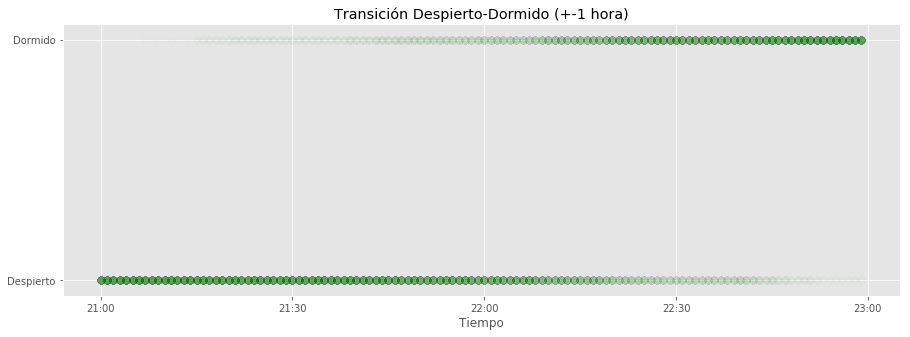

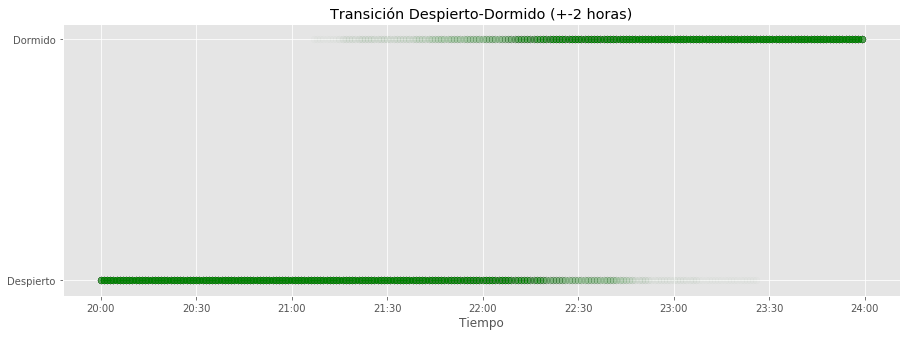

In [8]:
sleep_labels = ["20:00", "20:30", "21:00", "21:30", "22:00", "22:30", "23:00", "23:30", "24:00"]

plt.figure(figsize=(15, 5))
plt.scatter(sleep1['Offset'], sleep1['Sleep'], s=60, alpha=0.01, c='g')
plt.yticks([0, 1], ["Despierto", "Dormido"])
plt.xlabel("Tiempo")
plt.title("Transición Despierto-Dormido (+-1 hora)")
plt.xticks([-60, -30, 0, 30, 60], sleep_labels[2:]);

plt.figure(figsize=(15, 5))
plt.scatter(sleep2['Offset'], sleep2['Sleep'], s=50, alpha=0.01, c='g')
plt.yticks([0, 1], ["Despierto", "Dormido"])
plt.xlabel("Tiempo")
plt.title("Transición Despierto-Dormido (+-2 horas)")
plt.xticks([-120, -90, -60, -30, 0, 30, 60, 90, 120], sleep_labels);

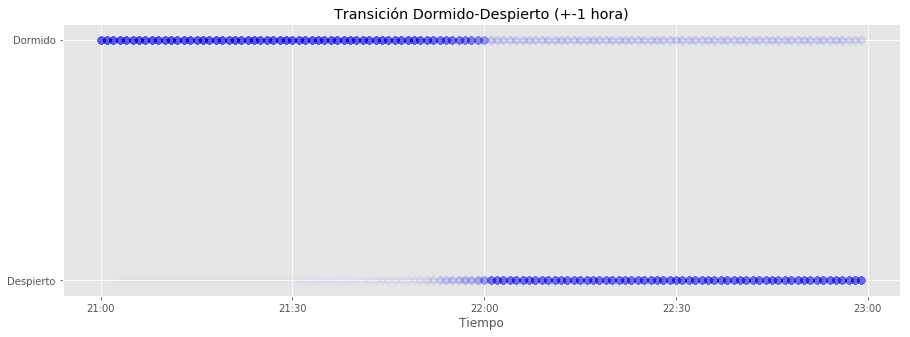

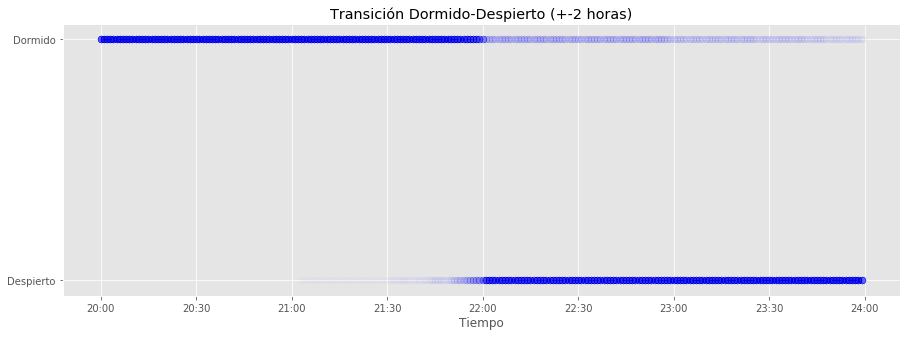

In [9]:
wake_labels = ["4:00", "4:30", "5:00", "5:30", "6:00", "6:30", "7:00", "7:30", "8:00"]

plt.figure(figsize=(15, 5))
plt.scatter(wake1['Offset'], wake1['Sleep'], s=60, alpha=0.01, c='b')
plt.yticks([1, 0], ["Dormido", "Despierto"])
plt.xlabel("Tiempo")
plt.title("Transición Dormido-Despierto (+-1 hora)")
plt.xticks([-60, -30, 0, 30, 60], sleep_labels[2:]);

plt.figure(figsize=(15, 5))
plt.scatter(wake2['Offset'], wake2['Sleep'], s=50, alpha=0.01, c='b')
plt.yticks([1, 0], ["Dormido", "Despierto"])
plt.xlabel("Tiempo")
plt.title("Transición Dormido-Despierto (+-2 horas)")
plt.xticks([-120, -90, -60, -30, 0, 30, 60, 90, 120], sleep_labels);

# 2) Función logística



\\[P(t) = \frac{1}{1+e^{-\beta t}}\\]



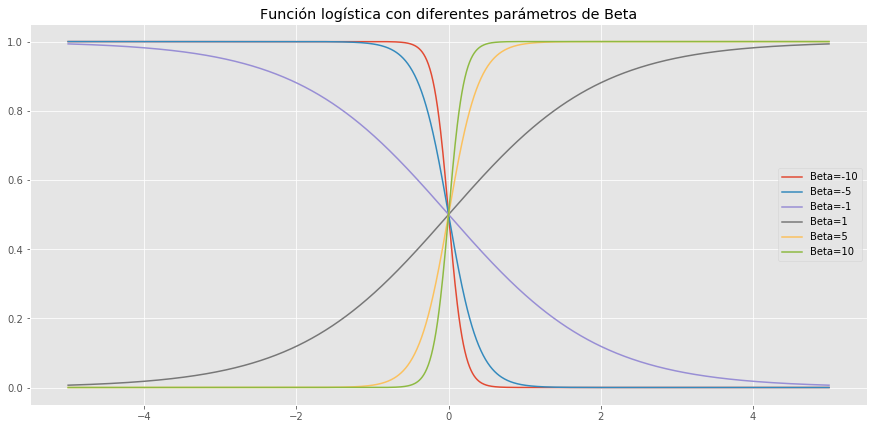

In [10]:
logistic = lambda x, beta : 1 / (1 + np.exp(-beta * x))

x = np.linspace(-5,5,1000)
beta = [-10, -5, -1, 1, 5, 10]

plt.figure(figsize=(15,7))
for b in beta:
    plt.plot(x, logistic(x, b), label="Beta="+str(b))
plt.title("Función logística con diferentes parámetros de Beta")
plt.legend()
plt.show()

Función logística 2

Como necesitamos una función que modele el problema y que no necesariamente esté centrada simétricamente en cero se utilizará la ecuación de Regresión logística, donde el término $\beta_0$ permitirá que la curva pueda moverse en el eje x. Con esto $\beta_0$ cambiará la ubicación de la curva y $\beta_1$ determinará la pendiende y dirreción.

\\[P(t) = \frac{1}{1+e^{-(\beta_0+\beta_1*t)}}\\]

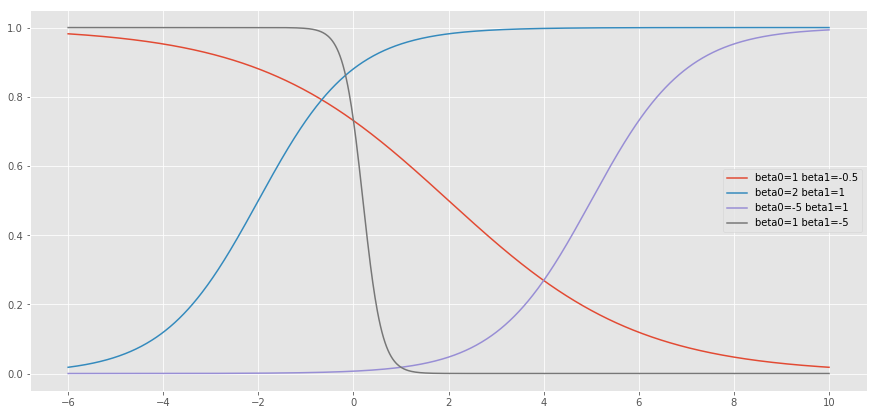

In [11]:
reg_logistic = lambda x, beta0, beta1 : 1 / (1 + np.exp(-(beta0 + beta1*x)))

x = np.linspace(-6,10,1000)
plt.figure(figsize=(15,7))
plt.plot(x, reg_logistic(x, 1, -0.5), label="beta0=1 beta1=-0.5")
plt.plot(x, reg_logistic(x, 2, 1), label="beta0=2 beta1=1")
plt.plot(x, reg_logistic(x, -5,1), label="beta0=-5 beta1=1")
plt.plot(x, reg_logistic(x, 1,-5), label="beta0=1 beta1=-5")
plt.legend()
plt.show()

# Modelomiento de los datos

Regresión logística bayesiana: las componentes dentro del *framework* bayesiano aosiado a la estimación de parámetros son: la distribución *prior*, la función de verosimilitud o *likelihood*, y la distribución a posterior. Estos términos se relacionan mediante la Regla de Bayes de la siguiente forma

\\[Posterior \propto Likelihood * Prior \\]

Por lo tanto la distribución a posterior contiene la información entregada por los datos, contenida en la likelihood, y la información que se tiene como conocimiento previo o proveniente de otras fuentes de información, contenida en el prior.

La función de likelihood, como se dijo anteriormente, contiene la información de los datos y proviene de una inferencia frecuentista. Dada la probabilidad de exito  la contribución del i-ésimo elemento se modela con una distribución binomial

\\[Likelihood_i = P(x_i) \\]

In [85]:
#Proposal distribution para los algoritmos a utilizar
mu = [0,0]
cov = 100*np.identity(2)
q = lambda x, mu: multivariate_normal.pdf(x, mu, cov)
#likelihood = lambda x, y, b0, b1: np.prod(bernoulli.pmf(y,reg_logistic(x, b0, b1)))

#Posterior p objetivo, la cual es complicada 
log_likelihood = lambda x, y, b0, b1: np.sum(np.log(bernoulli.pmf(y,reg_logistic(x, b0, b1))))
prior = lambda beta, mu, cov: multivariate_normal.pdf(beta, mu, cov)
p = lambda x, y, b0, b1, mu, cov: np.exp(log_likelihood(x, y, b0, b1) * prior([b0, b1], mu, cov))

In [86]:
#funciona!!
print(log_likelihood(sleep1['Offset'], sleep1['Sleep'],1.1,-0.08))
print(prior([1.1, -0.08], mu, cov))
p(x=sleep1['Offset'], y= sleep1['Sleep'], b0 = 1.1, b1 = -0.08, mu = mu, cov = cov)

-18809.832074815262
0.0015818990039764408


1.195245477522182e-13

## Metropolis Hasting